## Adquisicion y generacion de datos

En la primer celda, importamos librerias y definimos funciones

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np 
import matplotlib.pyplot as plt

import seaborn as sns 

def plot_2d_clasiffier(X, y, model, ax, h = .01):
    X = X.transpose()
    x_min, x_max = X[0].min(), X[0].max() 
    y_min, y_max = X[1].min(), X[1].max() 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    

    ax.imshow(Z, interpolation="nearest",extent=(xx.min(), xx.max(), yy.min(), yy.max()),cmap=plt.cm.Paired, aspect="auto", origin="lower",alpha=0.5)
    ax.scatter(X[0],X[1],c=y, alpha = 0.7, s = 10.)
    ax.grid(axis="both", alpha=0.7)
    ax.set(title = "Prediccion",xlabel = "$X_0$", ylabel = "$X_1$")
    ax.set_xlim([x_min, x_max]) 
    ax.set_ylim([y_min, y_max])



/home/JuanPabloDiBella/.local/share/virtualenvs/HOML-8cCrALvc/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Traemos los datos de make_moons, y los dividimos en trian y validation



<AxesSubplot:>

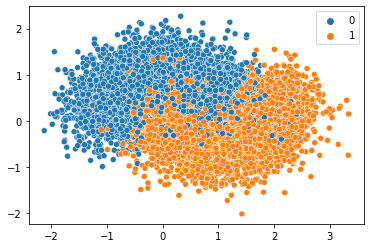

In [2]:
X, y = make_moons(n_samples=10000, noise=0.40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)

sns.scatterplot( x=[x[0] for x in X], y=[x[1] for x in X], hue = y)

## Voting clasiffier

Para ver el funcionamiento del voting clasiffier y como se compara con los clasificadores aislados. La siguiente celda crea un voting-classiffier de sklearn

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard')
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.84
RandomForestClassifier 0.854
SVC 0.898
VotingClassifier 0.884


## Bagging and Pasting in Scikit-Learn 
Scikit-Learn offers a simple API for both bagging and pasting with the
BaggingClassifier class (or BaggingRegressor for regression). The following code
trains an ensemble of 500 Decision Tree classifiers: 5 each is trained on 100 training
instances randomly sampled from the training set with replacement (this is an example
of bagging, but if you want to use pasting instead, just set bootstrap=False ). The
n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and
predictions ( –1 tells Scikit-Learn to use all available cores):


[Text(0.5, 1.0, 'Decision tree')]

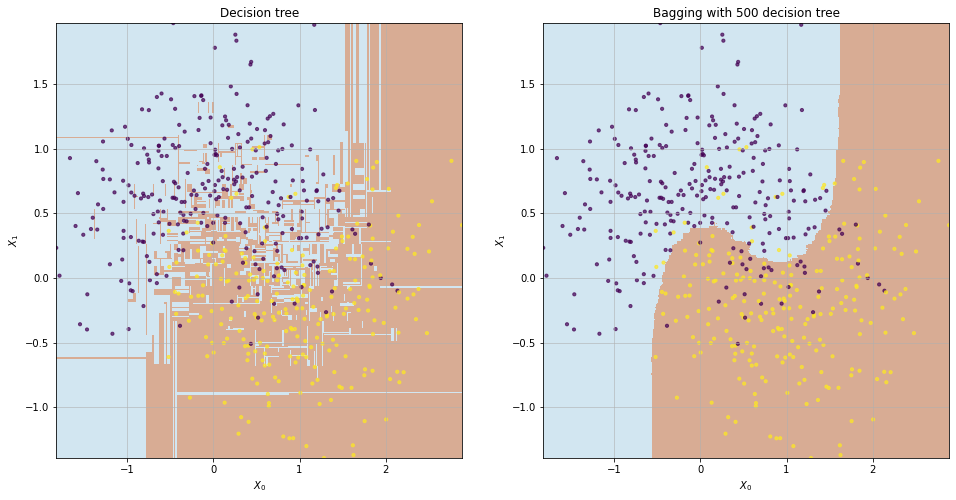

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_2d_clasiffier(X_val, y_val, bag_clf, ax[1])
plot_2d_clasiffier(X_val, y_val, dt_clf, ax[0])
ax[1].set(title ='Bagging with 500 decision tree')
ax[0].set(title ='Decision tree')

## OOB Scores : Out Of Bag

Primeor hago un chequeo numerico (por curiosidad) de cual es el porcentaje de datos usados cuando genero una submuestra con reposicion de una muetsra del mismo tamaño $N$

In [5]:
N = 100000

a = np.random.random(N)
a_bs = set([np.random.choice(a) for _ in range(N)])

print(f'a_bs tiene el % {100 * len(a_bs)/len(a)} de los datos de a')

a_bs tiene el % 63.229 de los datos de a


Armo un clasificador con 500 arboles y pruebo ambas metricas: sobre el set de validacion y el oob score

In [6]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)



from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_val)


print(f'OOB socre: {bag_clf.oob_score_} \nACC score: {accuracy_score(y_val, y_pred)}')

OOB socre: 0.8387368421052631 
ACC score: 0.844


## Random Forest

El siguiente bloque de codigo muestra rapidamente como un bagging de arboles de desicion es equivalente a un random Forest


In [7]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)


bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

rnd_clf.fit(X_train, y_train)
bag_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_val)
y_pred_bag = bag_clf.predict(X_val)


print(f'Accuracy on validation set for Random Forest : {accuracy_score(y_val, y_pred_rf)}')

print(f'Accuracy on validation set for Bagging Trees : {accuracy_score(y_val, y_pred_bag)}')


Accuracy on validation set for Random Forest : 0.894
Accuracy on validation set for Bagging Trees : 0.892


### MNIST feature importance plot

Un grafico de feature importance plot. Esto se puede hacer siempre que haya un arbol como modelo

[Text(0.5, 1.0, 'Feature values for random forest model to classify MNIST')]

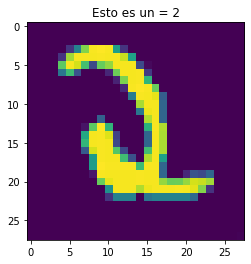

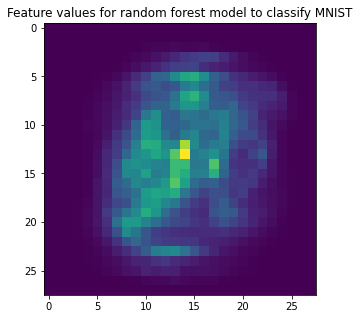

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784",version=1)

L = 10000
X = mnist['data']
y = mnist['target']
N = 400

digito_prueba_imagen = np.array(mnist['frame'].iloc[N])[1:].reshape(28,28).astype(int)
plt.imshow(digito_prueba_imagen)
plt.title('Esto es un = ' + y[N])
type(y[N])


rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)


features = rnd_clf.feature_importances_
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(features.reshape(28,28), cmap='viridis')
ax.set(title = 'Feature values for random forest model to classify MNIST')

## ADA Boost Funcoinamiento

ipykernel_launcher:5: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:5: RuntimeWarning: divide by zero encountered in log


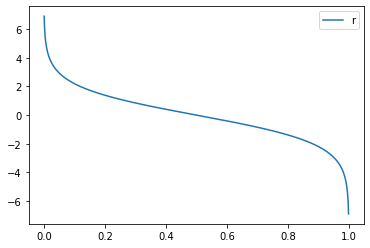

In [9]:
import matplotlib.pyplot as plt 
import numpy as np 

X = np.linspace(0,1,1000)
y = np.log((1-X)/X)
alpha = np.exp(y)
plt.plot(X, y, label='r')

plt.legend()

## Gradient Boost Desicion Tree (GBRT)

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)

y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)

y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)

y_pred = sum(tree.predict(X_train) for tree in (tree_reg1, tree_reg2, tree_reg3))
